# 我卷卷卷

在这节课中，我们学习了如何使用torchvision加载图像库，如何构建一个简单的卷积神经网络，并了解如何训练这个卷积神经网络
之后，我们还学会了如何对训练好的卷积网络进行分析

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第III课的配套源代码

In [16]:
# 导入所需要的包，请保证torchvision已经在你的环境中安装好.
# 在Windows需要单独安装torchvision包，在命令行运行pip install torchvision即可
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

import torchvision.datasets as dsets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## 一、加载数据

1. 首先，我们需要学习PyTorch自带的数据加载器，包括dataset，sampler，以及data loader这三个对象组成的套件。
2. 当数据集很小，格式比较规则的时候，数据加载三套件的优势并不明显。但是当数据格式比较特殊，以及数据规模很大（内存无法同时加载所有数据）
的时候，特别是，我们需要用不同的处理器来加载数据的时候，三套件的威力就会显现出来了。它会将数据加载、分布的任务自动完成。
3. 在使用的时候，我们用dataset来装载数据集，用sampler来采样数据集。而对数据集的迭代、循环则主要通过data_loader来完成。
4. 创建一个data_loader就需要一个dataset和一个datasampler，它基本实现的就是利用sampler自动从dataset种采样

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第III课的配套源代码

In [17]:
# 设置图像读取器的超参数
image_size = 28  #图像的总尺寸28*28
batch_size = 64  #批处理的尺寸大小

# 如果系统中存在着GPU，我们将用GPU来完成张量的计算
use_cuda = torch.cuda.is_available() #定义一个布尔型变量，标志当前的GPU是否可用

# 如果当前GPU可用，则将优先在GPU上进行张量计算
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
itype = torch.cuda.LongTensor if use_cuda else torch.LongTensor

# 加载MINIST数据，如果没有下载过，就会在当前路径下新建/data子目录，并把文件存放其中
# MNIST数据是属于torchvision包自带的数据，所以可以直接调用。
# 在调用自己的数据的时候，我们可以用torchvision.datasets.ImageFolder或者torch.utils.data.TensorDataset来加载

#定义一个数据输入函数，min为最小值，max为最大值
def dataset(min,max):
    train_dataset = dsets.MNIST(root='./data',  #文件存放路径
                            train=True,   #提取训练集
                            transform=transforms.ToTensor(),  #将图像转化为Tensor
                            download=True)

     # 加载测试数据集
    test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

    tr=((train_dataset.targets <=max)&(train_dataset.targets >=min)).nonzero().squeeze()
    train_dataset.targets=train_dataset.targets[tr]
    train_dataset.data=train_dataset.data[tr]
    
    te=((test_dataset.targets <=max)&(test_dataset.targets >=min)).nonzero().squeeze()
    test_dataset.targets=test_dataset.targets[te]
    test_dataset.data=test_dataset.data[te]
    #print(train_dataset)
    #print(test_dataset)
    
    
    # 训练数据集的加载器，自动将数据分割成batch，顺序随机打乱
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

     

     # 首先，我们定义下标数组indices，它相当于对所有test_dataset中数据的编码
     # 然后定义下标indices_val来表示校验集数据的那些下标，indices_test表示测试集的下标
    lens=len(test_dataset)
    indices = range(lens)
    indices_val = indices[:int(lens/2)]
    indices_test = indices[int(lens/2):]

    # 根据这些下标，构造两个数据集的SubsetRandomSampler采样器，它会对下标进行采样
    sampler_val = torch.utils.data.sampler.SubsetRandomSampler(indices_val)
    sampler_test = torch.utils.data.sampler.SubsetRandomSampler(indices_test)

    # 根据两个采样器来定义加载器，注意将sampler_val和sampler_test分别赋值给了validation_loader和test_loader
    validation_loader = torch.utils.data.DataLoader(dataset =test_dataset,
                                                batch_size = batch_size,
                                                sampler = sampler_val
                                               )
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          sampler = sampler_test
                                         )
    
    
    
    return(train_loader,validation_loader,test_loader)


In [19]:
train_loader,validation_loader, test_loader=dataset(0,4)
num_classes = 5  #标签的种类数
num_epochs = 100  #训练的总循环周期

标签是： 4


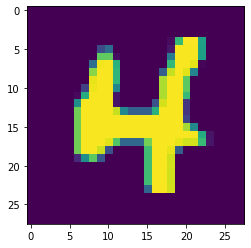

In [21]:
#随便从数据集中读入一张图片，并绘制出来
idx = 1004

#dataset支持下标索引，其中提取出来的每一个元素为features，target格式，即属性和标签。[0]表示索引features
muteimg = train_dataset[idx][0].numpy()
#由于一般的图像包含rgb三个通道，而MINST数据集的图像都是灰度的，只有一个通道。因此，我们忽略通道，把图像看作一个灰度矩阵。
#用imshow画图，会将灰度矩阵自动展现为彩色，不同灰度对应不同颜色：从黄到紫

plt.imshow(muteimg[0,...])
print('标签是：',train_dataset[idx][1])

## 二、基本的卷积神经网络

### 2.1 构建网络

注：在这里，我们将主要调用PyTorch强大的nn.Module这个类来构建卷积神经网络。我们分成如下这几个步骤：

1. 首先，我们构造ConvNet类，它是对类nn.Module的继承（即nn.Module是父类，ConvNet为子类。如果这些概念不熟悉，请参考面向对象编程）
2. 然后，我们复写__init__，以及forward这两个函数。第一个为构造函数，每当类ConvNet被具体化一个实例的时候，就会调用，forward则是
在运行神经网络正向的时候会被自动调用
3. 自定义自己的方法

另一需要理解的是，ConvNet其实也是一个大容器，它里面有Conv2d，MaxPool2d等组件

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第III课的配套源代码

In [22]:
#定义卷积神经网络：4和8为人为指定的两个卷积层的厚度（feature map的数量）
depth = [4, 8]
class ConvNet(nn.Module):
    def __init__(self):
        # 该函数在创建一个ConvNet对象的时候，即调用如下语句：net=ConvNet()，就会被调用
        # 首先调用父类相应的构造函数
        super(ConvNet, self).__init__()
        
        # 其次构造ConvNet需要用到的各个神经模块。
        '''注意，定义组件并没有真正搭建这些组件，只是把基本建筑砖块先找好'''
        self.conv1 = nn.Conv2d(1, 4, 5, padding = 2) #定义一个卷积层，输入通道为1，输出通道为4，窗口大小为5，padding为2
        self.pool = nn.MaxPool2d(2, 2) #定义一个Pooling层，一个窗口为2*2的pooling运算
        self.conv2 = nn.Conv2d(depth[0], depth[1], 5, padding = 2) #第二层卷积，输入通道为depth[0], 
                                                                   #输出通道为depth[1]，窗口为5，padding为2
        self.fc1 = nn.Linear(image_size // 4 * image_size // 4 * depth[1] , 512) 
                                                            #一个线性连接层，输入尺寸为最后一层立方体的平铺，输出层512个节点
        self.fc2 = nn.Linear(512, num_classes) #最后一层线性分类单元，输入为512，输出为要做分类的类别数

    def forward(self, x):
        #该函数完成神经网络真正的前向运算，我们会在这里把各个组件进行实际的拼装
        #x的尺寸：(batch_size, image_channels, image_width, image_height)
        x = F.relu(self.conv1(x))  #第一层卷积，激活函数用ReLu，为了防止过拟合
        #x的尺寸：(batch_size, num_filters, image_width, image_height)
        x = self.pool(x) #第二层pooling，将图片变小
        #x的尺寸：(batch_size, depth[0], image_width/2, image_height/2)
        x = F.relu(self.conv2(x)) #第三层又是卷积，窗口为5，输入输出通道分别为depth[0]=4, depth[1]=8
        #x的尺寸：(batch_size, depth[1], image_width/2, image_height/2)
        x = self.pool(x) #第四层pooling，将图片缩小到原大小的1/4
        #x的尺寸：(batch_size, depth[1], image_width/4, image_height/4)
        
        # 将立体的特征图Tensor，压成一个一维的向量
        # view这个函数可以将一个tensor按指定的方式重新排布。
        # 下面这个命令就是要让x按照batch_size * (image_size//4)^2*depth[1]的方式来排布向量
        x = x.view(-1, image_size // 4 * image_size // 4 * depth[1])
        #x的尺寸：(batch_size, depth[1]*image_width/4*image_height/4)
        
        x = F.relu(self.fc1(x)) #第五层为全链接，ReLu激活函数
        #x的尺寸：(batch_size, 512)

        x = F.dropout(x, training=self.training) #以默认为0.5的概率对这一层进行dropout操作，为了防止过拟合
        x = self.fc2(x) #全链接
        #x的尺寸：(batch_size, num_classes)
        
        x = F.log_softmax(x, dim = 0) #输出层为log_softmax，即概率对数值log(p(x))。采用log_softmax可以使得后面的交叉熵计算更快
        return x
    
    def retrieve_features(self, x):
        #该函数专门用于提取卷积神经网络的特征图的功能，返回feature_map1, feature_map2为前两层卷积层的特征图
        feature_map1 = F.relu(self.conv1(x)) #完成第一层卷积
        x = self.pool(feature_map1)  # 完成第一层pooling
        feature_map2 = F.relu(self.conv2(x)) #第二层卷积，两层特征图都存储到了feature_map1, feature_map2中
        return (feature_map1, feature_map2)
    

### 2.2 训练这个卷积神经网络

In [23]:
def rightness(predictions, labels):
    """计算预测错误率的函数，其中predictions是模型给出的一组预测结果，batch_size行num_classes列的矩阵，labels是数据之中的正确答案"""
    pred = torch.max(predictions.data, 1)[1] # 对于任意一行（一个样本）的输出值的第1个维度，求最大，得到每一行的最大元素的下标
    rights = pred.eq(labels.data.view_as(pred)).sum() #将下标与labels中包含的类别进行比较，并累计得到比较正确的数量
    return rights, len(labels) #返回正确的数量和这一次一共比较了多少元素


In [24]:
net = ConvNet() #新建一个卷积神经网络的实例，此时ConvNet的__init__函数就会被自动调用

criterion = nn.CrossEntropyLoss() #Loss函数的定义，交叉熵
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) #定义优化器，普通的随机梯度下降算法

record = [] #记录准确率等数值的容器
weights = [] #每若干步就记录一次卷积核

#开始训练循环
for epoch in range(num_epochs):
    
    train_rights = [] #记录训练数据集准确率的容器
    
    ''' 下面的enumerate是构造一个枚举器的作用。就是我们在对train_loader做循环迭代的时候，enumerate会自动吐出一个数字指示我们循环了几次
     这个数字就被记录在了batch_idx之中，它就等于0，1，2，……
     train_loader每迭代一次，就会吐出来一对数据data和target，分别对应着一个batch中的手写数字图，以及对应的标签。'''
    
    for batch_idx, (data, target) in enumerate(train_loader):  #针对容器中的每一个批进行循环
        data, target = data.clone().requires_grad_(True), target.clone().detach()  #data为一批图像，target为一批标签
        net.train() # 给网络模型做标记，标志说模型正在训练集上训练，
                    #这种区分主要是为了打开关闭net的training标志，从而决定是否运行dropout
            
        output = net(data) #神经网络完成一次前馈的计算过程，得到预测输出output
        loss = criterion(output, target) #将output与标签target比较，计算误差
        optimizer.zero_grad() #清空梯度
        loss.backward() #反向传播
        optimizer.step() #一步随机梯度下降算法
        right = rightness(output, target) #计算准确率所需数值，返回数值为（正确样例数，总样本数）
        train_rights.append(right) #将计算结果装到列表容器train_rights中

    
        if batch_idx % 100 == 0: #每间隔100个batch执行一次打印等操作
            
            net.eval() # 给网络模型做标记，标志说模型在训练集上训练
            val_rights = [] #记录校验数据集准确率的容器
            
            '''开始在校验数据集上做循环，计算校验集上面的准确度'''
            for (data, target) in validation_loader:
                data, target = data.clone().requires_grad_(True), target.clone().detach()
                output = net(data) #完成一次前馈计算过程，得到目前训练得到的模型net在校验数据集上的表现
                right = rightness(output, target) #计算准确率所需数值，返回正确的数值为（正确样例数，总样本数）
                val_rights.append(right)
            
            # 分别计算在目前已经计算过的测试数据集，以及全部校验集上模型的表现：分类准确率
            #train_r为一个二元组，分别记录目前已经经历过的所有训练集中分类正确的数量和该集合中总的样本数，
            #train_r[0]/train_r[1]就是训练集的分类准确度，同样，val_r[0]/val_r[1]就是校验集上的分类准确度
            train_r = (sum([tup[0] for tup in train_rights]), sum([tup[1] for tup in train_rights]))
            #val_r为一个二元组，分别记录校验集中分类正确的数量和该集合中总的样本数
            val_r = (sum([tup[0] for tup in val_rights]), sum([tup[1] for tup in val_rights]))
            #打印准确率等数值，其中正确率为本训练周期Epoch开始后到目前撮的正确率的平均值
            print(val_r)
            print('训练周期: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t训练正确率: {:.2f}%\t校验正确率: {:.2f}%'.format(
                epoch, batch_idx * batch_size, len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.data, 
                100. * train_r[0].numpy() / train_r[1], 
                100. * val_r[0].numpy() / val_r[1]))
            
            #将准确率和权重等数值加载到容器中，以方便后续处理
            record.append((100 - 100. * train_r[0] / train_r[1], 100 - 100. * val_r[0] / val_r[1]))
            
            # weights记录了训练周期中所有卷积核的演化过程。net.conv1.weight就提取出了第一层卷积核的权重
            # clone的意思就是将weight.data中的数据做一个拷贝放到列表中，否则当weight.data变化的时候，列表中的每一项数值也会联动
            '''这里使用clone这个函数很重要'''
            weights.append([net.conv1.weight.data.clone(), net.conv1.bias.data.clone(), 
                            net.conv2.weight.data.clone(), net.conv2.bias.data.clone()])
            

(tensor(541), 2569)
训练周期: 0 [0/30596 (0%)]	Loss: 1.611326	训练正确率: 23.44%	校验正确率: 21.06%
(tensor(2030), 2569)
训练周期: 0 [6400/30596 (21%)]	Loss: 1.585269	训练正确率: 32.67%	校验正确率: 79.02%
(tensor(2072), 2569)
训练周期: 0 [12800/30596 (42%)]	Loss: 1.394476	训练正确率: 45.51%	校验正确率: 80.65%
(tensor(2267), 2569)
训练周期: 0 [19200/30596 (63%)]	Loss: 0.725244	训练正确率: 55.20%	校验正确率: 88.24%
(tensor(2390), 2569)
训练周期: 0 [25600/30596 (84%)]	Loss: 0.233631	训练正确率: 63.22%	校验正确率: 93.03%
(tensor(2411), 2569)
训练周期: 1 [0/30596 (0%)]	Loss: 0.193261	训练正确率: 96.88%	校验正确率: 93.85%
(tensor(2436), 2569)
训练周期: 1 [6400/30596 (21%)]	Loss: 0.378305	训练正确率: 92.28%	校验正确率: 94.82%
(tensor(2450), 2569)
训练周期: 1 [12800/30596 (42%)]	Loss: 0.109230	训练正确率: 92.75%	校验正确率: 95.37%
(tensor(2461), 2569)
训练周期: 1 [19200/30596 (63%)]	Loss: 0.205859	训练正确率: 93.06%	校验正确率: 95.80%
(tensor(2477), 2569)
训练周期: 1 [25600/30596 (84%)]	Loss: 0.249509	训练正确率: 93.51%	校验正确率: 96.42%
(tensor(2475), 2569)
训练周期: 2 [0/30596 (0%)]	Loss: 0.121131	训练正确率: 96.88%	校验正确率: 96.34%
(tenso

(tensor(2549), 2569)
训练周期: 18 [0/30596 (0%)]	Loss: 0.031081	训练正确率: 100.00%	校验正确率: 99.22%
(tensor(2544), 2569)
训练周期: 18 [6400/30596 (21%)]	Loss: 0.182973	训练正确率: 98.82%	校验正确率: 99.03%
(tensor(2552), 2569)
训练周期: 18 [12800/30596 (42%)]	Loss: 0.063255	训练正确率: 98.80%	校验正确率: 99.34%
(tensor(2547), 2569)
训练周期: 18 [19200/30596 (63%)]	Loss: 0.100725	训练正确率: 98.71%	校验正确率: 99.14%
(tensor(2549), 2569)
训练周期: 18 [25600/30596 (84%)]	Loss: 0.067082	训练正确率: 98.70%	校验正确率: 99.22%
(tensor(2547), 2569)
训练周期: 19 [0/30596 (0%)]	Loss: 0.017747	训练正确率: 100.00%	校验正确率: 99.14%
(tensor(2547), 2569)
训练周期: 19 [6400/30596 (21%)]	Loss: 0.059279	训练正确率: 98.73%	校验正确率: 99.14%
(tensor(2547), 2569)
训练周期: 19 [12800/30596 (42%)]	Loss: 0.066663	训练正确率: 98.73%	校验正确率: 99.14%
(tensor(2544), 2569)
训练周期: 19 [19200/30596 (63%)]	Loss: 0.012481	训练正确率: 98.72%	校验正确率: 99.03%
(tensor(2547), 2569)
训练周期: 19 [25600/30596 (84%)]	Loss: 0.004597	训练正确率: 98.70%	校验正确率: 99.14%
(tensor(2542), 2569)
训练周期: 20 [0/30596 (0%)]	Loss: 0.070820	训练正确率: 98.44%	校验正确率:

(tensor(2556), 2569)
训练周期: 36 [0/30596 (0%)]	Loss: 0.007208	训练正确率: 100.00%	校验正确率: 99.49%
(tensor(2556), 2569)
训练周期: 36 [6400/30596 (21%)]	Loss: 0.004740	训练正确率: 99.23%	校验正确率: 99.49%
(tensor(2556), 2569)
训练周期: 36 [12800/30596 (42%)]	Loss: 0.146531	训练正确率: 99.23%	校验正确率: 99.49%
(tensor(2558), 2569)
训练周期: 36 [19200/30596 (63%)]	Loss: 0.022630	训练正确率: 99.18%	校验正确率: 99.57%
(tensor(2557), 2569)
训练周期: 36 [25600/30596 (84%)]	Loss: 0.016445	训练正确率: 99.21%	校验正确率: 99.53%
(tensor(2557), 2569)
训练周期: 37 [0/30596 (0%)]	Loss: 0.039641	训练正确率: 96.88%	校验正确率: 99.53%
(tensor(2553), 2569)
训练周期: 37 [6400/30596 (21%)]	Loss: 0.013911	训练正确率: 98.99%	校验正确率: 99.38%
(tensor(2557), 2569)
训练周期: 37 [12800/30596 (42%)]	Loss: 0.168822	训练正确率: 99.02%	校验正确率: 99.53%
(tensor(2554), 2569)
训练周期: 37 [19200/30596 (63%)]	Loss: 0.001930	训练正确率: 99.11%	校验正确率: 99.42%
(tensor(2557), 2569)
训练周期: 37 [25600/30596 (84%)]	Loss: 0.005462	训练正确率: 99.12%	校验正确率: 99.53%
(tensor(2556), 2569)
训练周期: 38 [0/30596 (0%)]	Loss: 0.009400	训练正确率: 100.00%	校验正确率:

(tensor(2556), 2569)
训练周期: 54 [0/30596 (0%)]	Loss: 0.006624	训练正确率: 100.00%	校验正确率: 99.49%
(tensor(2560), 2569)
训练周期: 54 [6400/30596 (21%)]	Loss: 0.024550	训练正确率: 99.07%	校验正确率: 99.65%
(tensor(2556), 2569)
训练周期: 54 [12800/30596 (42%)]	Loss: 0.026872	训练正确率: 99.25%	校验正确率: 99.49%
(tensor(2561), 2569)
训练周期: 54 [19200/30596 (63%)]	Loss: 0.000726	训练正确率: 99.28%	校验正确率: 99.69%
(tensor(2561), 2569)
训练周期: 54 [25600/30596 (84%)]	Loss: 0.003893	训练正确率: 99.33%	校验正确率: 99.69%
(tensor(2558), 2569)
训练周期: 55 [0/30596 (0%)]	Loss: 0.000971	训练正确率: 100.00%	校验正确率: 99.57%
(tensor(2554), 2569)
训练周期: 55 [6400/30596 (21%)]	Loss: 0.015593	训练正确率: 99.54%	校验正确率: 99.42%
(tensor(2554), 2569)
训练周期: 55 [12800/30596 (42%)]	Loss: 0.034165	训练正确率: 99.52%	校验正确率: 99.42%
(tensor(2557), 2569)
训练周期: 55 [19200/30596 (63%)]	Loss: 0.011158	训练正确率: 99.49%	校验正确率: 99.53%
(tensor(2556), 2569)
训练周期: 55 [25600/30596 (84%)]	Loss: 0.096794	训练正确率: 99.44%	校验正确率: 99.49%
(tensor(2561), 2569)
训练周期: 56 [0/30596 (0%)]	Loss: 0.123982	训练正确率: 96.88%	校验正确率:

(tensor(2560), 2569)
训练周期: 72 [0/30596 (0%)]	Loss: 0.004547	训练正确率: 100.00%	校验正确率: 99.65%
(tensor(2559), 2569)
训练周期: 72 [6400/30596 (21%)]	Loss: 0.002875	训练正确率: 99.50%	校验正确率: 99.61%
(tensor(2560), 2569)
训练周期: 72 [12800/30596 (42%)]	Loss: 0.005985	训练正确率: 99.56%	校验正确率: 99.65%
(tensor(2559), 2569)
训练周期: 72 [19200/30596 (63%)]	Loss: 0.001319	训练正确率: 99.56%	校验正确率: 99.61%
(tensor(2562), 2569)
训练周期: 72 [25600/30596 (84%)]	Loss: 0.002793	训练正确率: 99.56%	校验正确率: 99.73%
(tensor(2560), 2569)
训练周期: 73 [0/30596 (0%)]	Loss: 0.007319	训练正确率: 100.00%	校验正确率: 99.65%
(tensor(2560), 2569)
训练周期: 73 [6400/30596 (21%)]	Loss: 0.001775	训练正确率: 99.61%	校验正确率: 99.65%
(tensor(2559), 2569)
训练周期: 73 [12800/30596 (42%)]	Loss: 0.002228	训练正确率: 99.60%	校验正确率: 99.61%
(tensor(2561), 2569)
训练周期: 73 [19200/30596 (63%)]	Loss: 0.000799	训练正确率: 99.62%	校验正确率: 99.69%
(tensor(2561), 2569)
训练周期: 73 [25600/30596 (84%)]	Loss: 0.010426	训练正确率: 99.62%	校验正确率: 99.69%
(tensor(2557), 2569)
训练周期: 74 [0/30596 (0%)]	Loss: 0.001790	训练正确率: 100.00%	校验正确率

(tensor(2563), 2569)
训练周期: 90 [0/30596 (0%)]	Loss: 0.000351	训练正确率: 100.00%	校验正确率: 99.77%
(tensor(2557), 2569)
训练周期: 90 [6400/30596 (21%)]	Loss: 0.001586	训练正确率: 99.72%	校验正确率: 99.53%
(tensor(2563), 2569)
训练周期: 90 [12800/30596 (42%)]	Loss: 0.013936	训练正确率: 99.76%	校验正确率: 99.77%
(tensor(2561), 2569)
训练周期: 90 [19200/30596 (63%)]	Loss: 0.000041	训练正确率: 99.71%	校验正确率: 99.69%
(tensor(2560), 2569)
训练周期: 90 [25600/30596 (84%)]	Loss: 0.000697	训练正确率: 99.70%	校验正确率: 99.65%
(tensor(2561), 2569)
训练周期: 91 [0/30596 (0%)]	Loss: 0.001016	训练正确率: 100.00%	校验正确率: 99.69%
(tensor(2561), 2569)
训练周期: 91 [6400/30596 (21%)]	Loss: 0.000890	训练正确率: 99.68%	校验正确率: 99.69%
(tensor(2561), 2569)
训练周期: 91 [12800/30596 (42%)]	Loss: 0.000411	训练正确率: 99.70%	校验正确率: 99.69%
(tensor(2561), 2569)
训练周期: 91 [19200/30596 (63%)]	Loss: 0.000795	训练正确率: 99.67%	校验正确率: 99.69%
(tensor(2561), 2569)
训练周期: 91 [25600/30596 (84%)]	Loss: 0.000185	训练正确率: 99.68%	校验正确率: 99.69%
(tensor(2561), 2569)
训练周期: 92 [0/30596 (0%)]	Loss: 0.004966	训练正确率: 100.00%	校验正确率

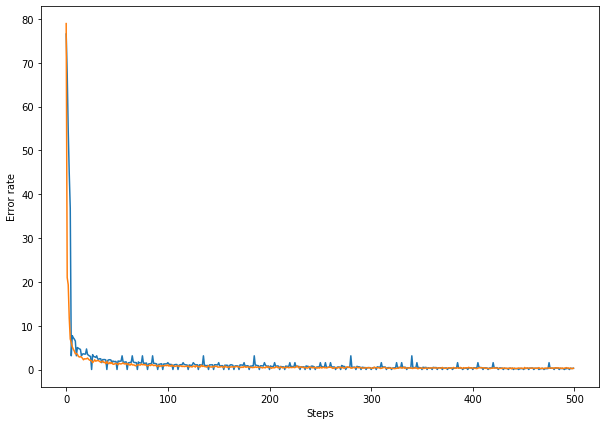

In [28]:
#绘制训练过程的误差曲线，校验集和测试集上的错误率。
plt.figure(figsize = (10, 7))
plt.plot(record) #record记载了每一个打印周期记录的训练和校验数据集上的准确度
plt.xlabel('Steps')
plt.ylabel('Error rate')
plt.savefig('minst_conv_0-4.jpg', dpi=300) 

In [27]:
# 在这里保存已经训练好的神经网络
torch.save(net, 'minst_conv_0-4_checkpoint') #后面的字符串为保存文件的路径